In [1]:
import numpy as np
from scipy.signal import ShortTimeFFT
import load_data
from matplotlib import pyplot as plt

In [10]:
def down_sampling(data,samplerate,target_fre):
    factor = int(samplerate /target_fre)
    return int(samplerate/factor),data[::factor]
def plot_signal(data,title,fs):
    plt.plot(np.linspace(0, len(data)/fs, len(data)), data)
    plt.title(title)
    plt.show()
    return

In [6]:
from scipy.io import wavfile
data_path='./data/clean/New_N_048.wav'
fs,data=load_data.load_wav(data_path)
test_data=np.tile(data,10)
wavfile.write('test_clean_pcg.wav',fs,test_data)

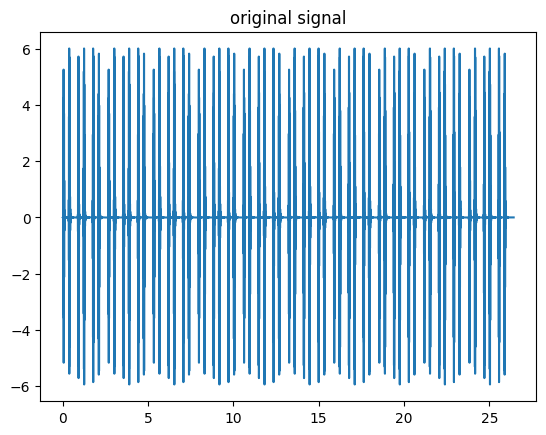

In [11]:

test_data='./test_clean_pcg.wav'
fs,data=load_data.load_wav(test_data)

data= load_data.pre_process(data)
plot_signal(data,'original signal',fs)



# Phase 2 non-cardiac sound detection

In [16]:
# spectral energy
def stft_win(signal,fs):
    N=len(signal)
    x=np.linspace(0, N - 1, N)
    win_temp=np.hanning(N)
    win=np.array([0 if idx > N / 2 else x for x,idx in enumerate(win_temp)])
    SFT=ShortTimeFFT(win=win,fs=fs,hop=1)
    STFT=np.real(SFT.stft(signal))
    return STFT
def root_mean_square(stft):
    s_rms=np.zeros(stft.shape[0])
    for i in range(stft.shape[0]):
        s_rms[i]=np.sqrt(np.sum(stft[i]**2))
    return s_rms
def srms_evaluate(ref_rms,test_rms):
    coef=np.corrcoef(ref_rms,test_rms)[0][1]
    if coef>0.98:
        print("Segment passed spectral RMS test")
        return True
    else:
        print("Segment failed spectral RMS test, correlation coefficient:",coef)
        return False



STFT_ref=stft_win(data_time_ref,samplerate)
STFT_test=stft_win(data_time_test,samplerate)
coef=srms_evaluate(root_mean_square(STFT_ref),root_mean_square(STFT_test))

Segment failed spectral RMS test, correlation coefficient: 0.8995307290132335


In [ ]:
# temporal energy
def ref_max_te(ref,fs):
    tw=0.05*fs
    max_te=0
    for i in range(0,len(ref),tw):
        te=np.sum([x**2 for x in ref[i:i+tw]])
        if te>max_te:
            max_te=te
    return max_te

def test_rte(test,fs,ref_te):
    tw=0.05*fs
    rte=np.zeros(len(test)//tw)
    for i in range(0,len(test),tw):
        rte[i]=np.sum([x**2 for x in test[i:i+tw]])/ref_te
    return rte

def te_evaluate(rte):
    for r in rte:
        if r>3:
            print("failed temporal energy test with relative temporal energy ",r)
            return False
    print("passed temporal energy test")
    return True
